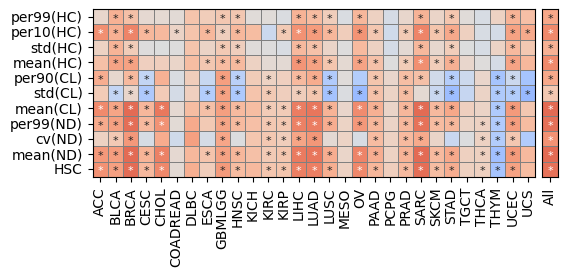

In [34]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import itertools
from statannotations.Annotator import Annotator
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.stats.multitest import multipletests

def calculate_corr_matrix(df1, df2, method='pearson', pvalue_correction="fdr_bh"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")
    
    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            df_no_na = pd.concat([df1[row], df2[col]], axis=1)
            df_no_na = df_no_na.dropna(axis=0, how="any")
            if method == 'spearman':
                corr, pvalue = stats.spearmanr(df_no_na[row], df_no_na[col])
            elif method == 'pearson':
                corr, pvalue = stats.pearsonr(df_no_na[row], df_no_na[col])
            corr_matrix.at[row, col] = np.float32(corr)
            pvalue_matrix.at[row, col] = np.float32(pvalue)
    # correcting pvalues for the number of genes
    if pvalue_correction is not None:
        # Flatten the DataFrame to a 1D array
        pvals = pvalue_matrix.values.flatten()
        # Apply the correction
        corrected_pvals = multipletests(pvals, alpha=0.05, method=pvalue_correction)[1]
        # Reshape the corrected p-values back to the original shape of pvalue_matrix
        corrected_pvals_matrix = corrected_pvals.reshape(pvalue_matrix.shape)
        # Replace the values in the original DataFrame
        pvalue_matrix.loc[:, :] = corrected_pvals_matrix

    return corr_matrix, pvalue_matrix

ALL_CANCERS = ['SARC',
    'LIHC',
    'THYM',
    'ACC',
    'BRCA',
    'KICH',
    'STAD',
    'BLCA',
    'THCA',
    'GBMLGG',
    'UCEC',
    'LUAD',
    'KIRC',
    'KIRP',
    'PAAD',
    'CESC',
    'PCPG',
    'MESO',
    'SKCM',
    'PRAD',
    'COADREAD',
    'ESCA',
    'LUSC',
    'HNSC',
    'OV',
    'TGCT',
    'CHOL',
    'DLBC',
    'UCS'
 ]


# keep only columns that are related to mutations
mnai_df = pd.read_csv("gene/data/MNAI_gene_data.csv")
mnai_df["type"] = mnai_df["type"].replace(["GBM", "LGG"], "GBMLGG")

selected_feats = [
"mit_hotspot_count",
"mit_nodeDegrees_mean",
"mit_nodeDegrees_cv",
"mit_nodeDegrees_per99",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_per90",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
"mit_cenHarmonic_per10",
"mit_cenHarmonic_per99",
]
mitosis_feats = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type", "temperature"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type", "temperature"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")
mitosis_feats["type"] = mitosis_feats["type"].replace(["GBM", "LGG"], "GBMLGG")

all_corr = []
all_pval = []


for cancer_type in sorted(ALL_CANCERS) + ["All"]:

    if cancer_type in ["All"]:
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"].isin(ALL_CANCERS)]
        gene_exp_cancer = mnai_df[mnai_df["type"].isin(ALL_CANCERS)]
    else:
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
        gene_exp_cancer = mnai_df[mnai_df["type"]==cancer_type]

    if cancer_type=="Mitotic Hot":
        mitosis_feats_cancer = mitosis_feats_cancer[mitosis_feats_cancer["temperature"]=="Hot"]
    if cancer_type=="Mitotic Cold":
        mitosis_feats_cancer = mitosis_feats_cancer[mitosis_feats_cancer["temperature"]=="Cold"]


    # drop missing mutations
    gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")
    # drop cases with all mutations as Nan


    # Find the common case names between mitosis features and gene expressions
    common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['case_id']))))
    ## Keep only the rows with the common case names in both dataframes
    df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
    df2_common = gene_exp_cancer[gene_exp_cancer['case_id'].isin(common_cases)]
    df2_common = df2_common.drop_duplicates(subset='case_id')

    ## Sort the dataframes based on 'case_name'
    df1_common = df1_common.sort_values('bcr_patient_barcode')
    df2_common = df2_common.sort_values('case_id')

    df1_common = df1_common.reset_index(drop=True)
    df2_common = df2_common.reset_index(drop=True)

    X = df2_common[["MNAI"]]
    Y = df1_common[['HSC', 'mean(ND)',
       'cv(ND)', 'per99(ND)', 'mean(CL)', 'std(CL)', 'per90(CL)', 'mean(HC)',
       'std(HC)', 'per10(HC)', 'per99(HC)'][::-1]]
    corr_matrix, pvalue_matrix = calculate_corr_matrix(Y, X, method='spearman', pvalue_correction="bonferroni")

    all_corr.append(corr_matrix.rename(columns={"MNAI": cancer_type}))
    all_pval.append(pvalue_matrix.rename(columns={"MNAI": cancer_type}))

corr_matrix = pd.concat(all_corr, axis=1)
pvalue_matrix = pd.concat(all_pval, axis=1)
annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '') 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 7), gridspec_kw={'width_ratios': [corr_matrix.shape[1]-1, 1]})
# Plot the heatmap for all but the last column
heatmap1 = sns.heatmap(corr_matrix.iloc[:, :-1], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, :-1], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=True, xticklabels=True, ax=ax1)

heatmap2 = sns.heatmap(corr_matrix.iloc[:, -1:], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, -1:], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=False, xticklabels=True, ax=ax2)


for _, spine in heatmap1.spines.items():
    spine.set_visible(True)

for _, spine in heatmap2.spines.items():
    spine.set_visible(True)


for label in heatmap2.get_xticklabels():
    label.set_rotation(90)

plt.subplots_adjust(wspace=0.03, hspace=0)

# plt.savefig("results_final/gene/expression/mnai_correlations.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
# plt.savefig("results_final/gene/expression/mnai_correlations.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)

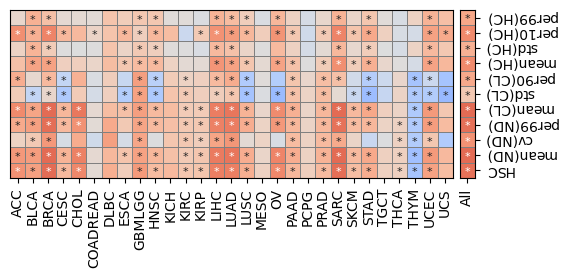

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 7), gridspec_kw={'width_ratios': [corr_matrix.shape[1]-1, 1]})

# Plot the heatmap for all but the last column
heatmap1 = sns.heatmap(corr_matrix.iloc[:, :-1], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, :-1], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=True, xticklabels=True, ax=ax1)

heatmap2 = sns.heatmap(corr_matrix.iloc[:, -1:], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, -1:], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=True, xticklabels=True, ax=ax2)

# Move y-axis ticks and labels from ax1 to ax2
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Hide y-axis ticks and labels on ax2
ax1.yaxis.set_ticks([])
ax1.yaxis.set_ticklabels([])

for _, spine in heatmap1.spines.items():
    spine.set_visible(True)

for _, spine in heatmap2.spines.items():
    spine.set_visible(True)

for label in heatmap2.get_xticklabels():
    label.set_rotation(90)

for label in heatmap2.get_yticklabels():
    label.set_rotation(180)
    label.set_rotation_mode('anchor')
    label.set_ha('right')  # Horizontal alignment
    # label.set_va('center')  # Vertical alignment



plt.subplots_adjust(wspace=0.03, hspace=0)

plt.savefig("results_final/gene/expression/mnai_correlations_rotated.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
plt.savefig("results_final/gene/expression/mnai_correlations_rotated.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)


In [ ]:
immune_df = pd.read_excel("gene/data/tcga-immune.xlsx")
immune_df["TCGA Study"] = immune_df["TCGA Study"].replace(["COAD", "READ"], "COADREAD")


****************************** ACC. 1
****************************** AML. 0
****************************** AML.1 0
****************************** AML.2 0
****************************** AML.3 0
****************************** AML.4 0
****************************** AML.5 0
****************************** AML.6 0
****************************** AML.7 0
****************************** PRAD.1-ERG 0
****************************** PRAD.2-ETV1 0
****************************** PRAD.3-ETV4 0
****************************** PRAD.4-FLI1 0
****************************** PRAD.5-SPOP 0
****************************** PRAD.6-FOXA1 0
****************************** PRAD.7-IDH1 0
****************************** PRAD.8-other 0
****************************** THCA. 0
****************************** THCA.1 0
****************************** THCA.2 0
****************************** THCA.3 0
****************************** THCA.4 0
****************************** THCA.5 0
****************************** UCS.1 0
************

C:\Users\u2070124\AppData\Local\Temp\ipykernel_22216\1431919468.py:133: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '')


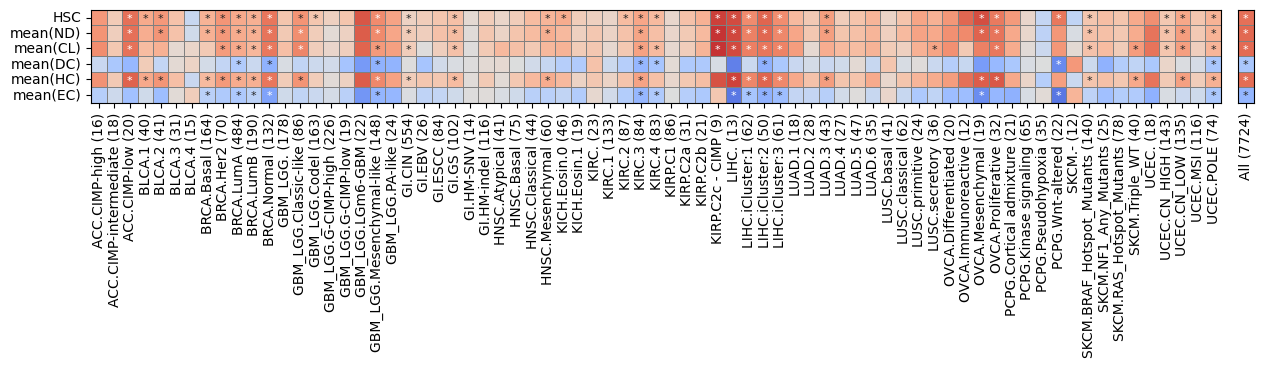

In [1]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import itertools
from statannotations.Annotator import Annotator
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.stats.multitest import multipletests

def calculate_corr_matrix(df1, df2, method='pearson', pvalue_correction="fdr_bh"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")
    
    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            df_no_na = pd.concat([df1[row], df2[col]], axis=1)
            df_no_na = df_no_na.dropna(axis=0, how="any")
            if method == 'spearman':
                corr, pvalue = stats.spearmanr(df_no_na[row], df_no_na[col])
            elif method == 'pearson':
                corr, pvalue = stats.pearsonr(df_no_na[row], df_no_na[col])
            corr_matrix.at[row, col] = np.float32(corr)
            pvalue_matrix.at[row, col] = np.float32(pvalue)
    # correcting pvalues for the number of genes
    if pvalue_correction is not None:
        # Flatten the DataFrame to a 1D array
        pvals = pvalue_matrix.values.flatten()
        # Apply the correction
        corrected_pvals = multipletests(pvals, alpha=0.05, method=pvalue_correction)[1]
        # Reshape the corrected p-values back to the original shape of pvalue_matrix
        corrected_pvals_matrix = corrected_pvals.reshape(pvalue_matrix.shape)
        # Replace the values in the original DataFrame
        pvalue_matrix.loc[:, :] = corrected_pvals_matrix

    return corr_matrix, pvalue_matrix

ALL_CANCERS = ['BRCA', 'KIRC', 'UCEC', 'LGG', 'LUSC', 'LUAD', 'HNSC', 'COADREAD', 'SKCM',
                'GBM', 'BLCA', 'STAD', 'LIHC', 'KIRP', 'CESC', 'PAAD', 'ESCA', 'PCPG', 'KICH', 'OV']

immune_df = pd.read_excel("gene/data/tcga-immune.xlsx")
immune_df["TCGA Study"] = immune_df["TCGA Study"].replace(["COAD", "READ"], "COADREAD")
subtypes = sorted(immune_df['TCGA Subtype'].dropna().unique())

# keep only columns that are related to mutations
mnai_df = pd.read_csv("gene/data/MNAI_gene_data.csv")
mnai_df["type"] = mnai_df["type"].replace(["COAD", "READ"], "COADREAD")

selected_feats = [
"mit_wsi_count",
"mit_hotspot_count",
"mit_nodeDegrees_mean",
"mit_nodeDegrees_max",
"mit_nodeDegrees_std",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_perc10",
"mit_clusterCoff_perc80",
"mit_cenDegree_mean",
"mit_cenDegree_std",
"mit_cenCloseness_max",
"mit_cenEigen_mean",
"mit_cenEigen_max",
"mit_cenEigen_std",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
]
mitosis_feats = pd.read_csv('D:/tcga/tcga_mitosis_ClusterByCancer.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type", "temperature"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type", "temperature"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")

all_corr = []
all_pval = []


for cancer_type in subtypes + ["All"]:

    if cancer_type in ["All"]:
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"].isin(ALL_CANCERS)]
        gene_exp_cancer = mnai_df[mnai_df["type"].isin(ALL_CANCERS)]
    else:
        cases = immune_df[immune_df["TCGA Subtype"]==cancer_type]["TCGA Participant Barcode"].to_list()
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["bcr_patient_barcode"].isin(cases)]
        gene_exp_cancer = mnai_df[mnai_df["case_id"].isin(cases)]

    if len(mitosis_feats_cancer) < 5:
        print(30*"*", cancer_type, len(mitosis_feats_cancer))
        continue

    # drop missing mutations
    gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")

    # Find the common case names between mitosis features and gene expressions
    common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['case_id']))))
    ## Keep only the rows with the common case names in both dataframes
    df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
    df2_common = gene_exp_cancer[gene_exp_cancer['case_id'].isin(common_cases)]
    df2_common = df2_common.drop_duplicates(subset='case_id')

    ## Sort the dataframes based on 'case_name'
    df1_common = df1_common.sort_values('bcr_patient_barcode')
    df2_common = df2_common.sort_values('case_id')

    df1_common = df1_common.reset_index(drop=True)
    df2_common = df2_common.reset_index(drop=True)

    X = df2_common[["MNAI"]]
    Y = df1_common[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "mean(HC)", "mean(EC)"]]
    corr_matrix, pvalue_matrix = calculate_corr_matrix(Y, X, method='spearman', pvalue_correction="bonferroni")

    row_name = f"{cancer_type} ({len(mitosis_feats_cancer)})"
    all_corr.append(corr_matrix.rename(columns={"MNAI": row_name}))
    all_pval.append(pvalue_matrix.rename(columns={"MNAI": row_name}))

corr_matrix = pd.concat(all_corr, axis=1)
pvalue_matrix = pd.concat(all_pval, axis=1)
annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '') 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [corr_matrix.shape[1]-1, 1]})
# Plot the heatmap for all but the last column
heatmap1 = sns.heatmap(corr_matrix.iloc[:, :-1], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, :-1], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=True, xticklabels=True, ax=ax1)

heatmap2 = sns.heatmap(corr_matrix.iloc[:, -1:], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, -1:], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=False, xticklabels=True, ax=ax2)


for _, spine in heatmap1.spines.items():
    spine.set_visible(True)

for _, spine in heatmap2.spines.items():
    spine.set_visible(True)


for label in heatmap2.get_xticklabels():
    label.set_rotation(90)

plt.subplots_adjust(wspace=0.03, hspace=0)

# plt.savefig("gene/expression/MNAI_correlations.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
# plt.savefig("gene/expression/MNAI_correlations.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)

In [1]:
import pandas as pd 

MNAI_genes = [ "AURKA",
"AURKB", "BUB1", "CENPE", "CHEK1", "FOXM1", "MELK", "PBK", "PLK1",
"TTK", "TYMS", "ASPM", "BUB1B", "CCNA2", "CCNB1", "CCNB2", "CDC20",
"CDCA3", "CDCA8", "CENPA", "CENPN", "CEP55", "DEPDC1",
"DLGAP5", "EXO1", "EXOSC9", "HJURP", "KIF14", "KIF18B",
"KIF20A", "KIF23", "KIF2C", "KIF4A", "LMNB2", "MAD2L1", "MCM10",
"MKI67", "NCAPD2", "NCAPG", "NCAPG2", "NCAPH", "NDC80", "PRC1",
"PTTG1", "RFC3", "RRM2", "SMC4", "STIL", "TEX10", "TPX2", "UBE2S", "DDX39", "FAM64A"]

mitsa_genes = ["BIRC5",
"CDC45",
"FAM72B",
"EME1",
"OIP5",
"CCNA2",
"SKA3",
"CDT1",
"CKS1B",
"E2F2",
"MCM4",
"KIF2C",
"GINS4",
"POLE2",
"AURKB",
"DTL",
"CDCA8",
"CCNB2",
"RAD51AP1",
"FANCA",
"GSG2",
"FAM72D",
"EZH2",
"FAM54A",
"CKAP2L",
"CEP55",
"PRC1",
"C17orf53",
"TK1",
"C11orf82",
"NEK2",
"PLK4",
"FANCD2",
"CENPF",
"C12orf48",
"TACC3",
"EPR1",
"KIF20A",
"CCNB1",
"IQGAP3",
"C1orf135",
"ASF1B",
"KIFC1",
"FAM83D",
"CDC25A",
"KIF4B",
"SGOL1",
"KPNA2",
"MAD2L1",
"MND1",
"GTSE1",
"DEPDC1",
"GINS1",
"E2F7",
"ARHGAP11A",
"FEN1",
"CENPI",
"RFC4",
"CDC25C",
"MKI67",
"CENPE",
"NCAPD2",
"FAM64A",
"WDR62",
"CENPN",
"BUB1B",
"POLQ",
"KIF14",
"TIMELESS",
"MCM2",
"FAM72A",
"TPX2",
"TROAP",
"DSCC1",
"NEIL3",
"RAD51",
"MELK",
"KIF18B",
"KIF18A",
"HELLS",
"ZWINT",
"KIF4A",
"ERCC6L",
"PKMYT1",
"BUB1",
"NCAPH",
"PLK1",
"NFKBIL2",
"NUF2",
"FANCB",
"CCNF",
"CDC6",
"UHRF1",
"CHEK1",
"ESCO2",
"CDKN3",
"KIF15",
"TTK",
"ECT2",
"RRM2",
"SPC25",
"ZWILCH",
"CDK1",
"TRIP13",
"CDC20",
"AURKA",
"UBE2C",
"E2F8",
"RACGAP1",
"CDCA3",
"FOXM1",
"CENPA",
"C15orf42",
"EXO1",
"ASPM",
"TOP2A",
"NUSAP1",
"KIF11",
"RAD54L",
"LMNB1",
"RECQL4",
"SPAG5",
"SKA1",
"PTTG1",
"CENPW",
"KIAA1524",
"STIL",
"MYBL2",
"HMMR",
"FANCI",
"MCM10",
"ORC1L",
"NDC80",
"ORC6L",
"CDCA4",
"NCAPG",
"HJURP",
"DLGAP5",
"SHCBP1",
"UBE2T",
"ESPL1",
"CDCA5",
"KIF23",]

shared_genes = set(MNAI_genes).intersection(set(mitsa_genes))
genes_in_mitsa_notin_mnai = set(mitsa_genes).difference(set(MNAI_genes))
genes_in_mnai_notin_mitsa = set(MNAI_genes).difference(set(mitsa_genes))

print("shared_genes", len(shared_genes))
print("genes_in_mitsa_notin_mnai", len(genes_in_mitsa_notin_mnai))
print("genes_in_mnai_notin_mitsa", len(genes_in_mnai_notin_mitsa))

signatures = pd.read_csv("gene/data/signatures.csv")
signatures["MNAI"] = pd.Series(MNAI_genes)

shared_genes 43
genes_in_mitsa_notin_mnai 100
genes_in_mnai_notin_mitsa 10


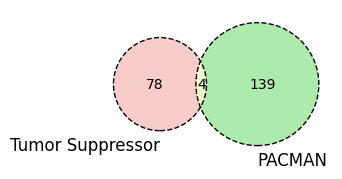

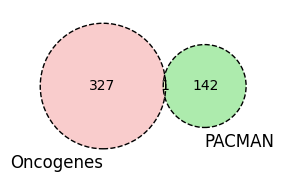

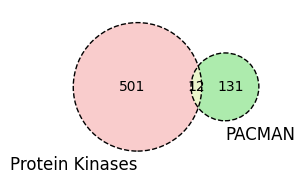

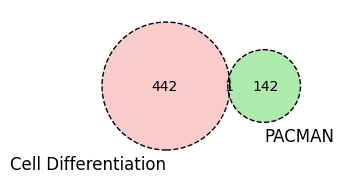

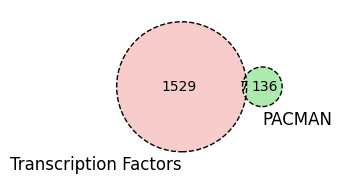

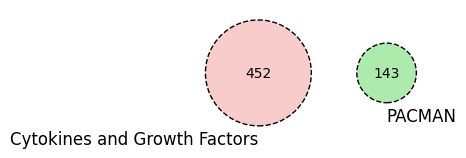

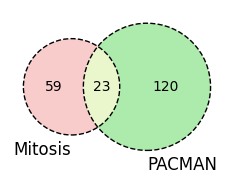

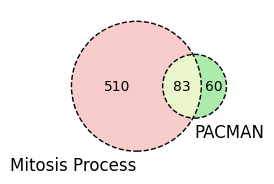

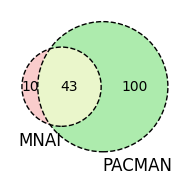

In [3]:
from matplotlib_venn import venn2 ,venn2_circles
from matplotlib import pyplot as plt 
  


for sig in signatures.columns:
    gene_test = signatures[sig].dropna().to_list()
    # depict venn diagram 
    fig, ax = plt.subplots(1,1,figsize=(3,2))
    venn2(subsets = (set(gene_test), set(mitsa_genes)), set_labels = (sig, 'PACMAN'), ax=ax, set_colors=("lightcoral", "limegreen")) 
    venn2_circles(subsets=(set(gene_test), set(mitsa_genes)), ax=ax,  
              linestyle="dashed", linewidth=1) 
    plt.savefig(f"results_final/gene/expression/PACMAN_{sig}_VENN.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
import matplotlib.pyplot as plt

from matplotlib_set_diagrams import (
    EulerDiagram,
    VennDiagram,
)

fig, ax = plt.subplots(1,1, figsize=(20,16))
EulerDiagram.as_wordcloud([set(gene_test), set(mitsa_genes)], minimum_resolution=1200, set_labels =(sig, "PACMAN"), set_colors=("lightcoral", "limegreen"),  ax=ax)
fig.savefig("results_final/gene/expression/MNAI_PACMAN_EULER.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
